# CNN model using Pytorch

## Import libraries

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


## Load the Data

In [2]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/guare13/handwritten-letters-recognition
License(s): CC0-1.0
handwritten-letters-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  handwritten-letters-recognition.zip
replace test_letters/letter_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## View Data

In [3]:
# Preparar el dataset
train_data = pd.read_csv('written_letters_train.csv')
valid_data = pd.read_csv('written_letters_validation.csv')

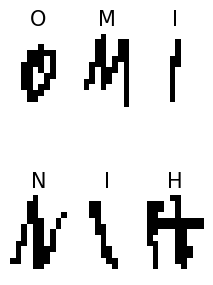

In [4]:
plt.figure(figsize=(2.5, 3.5))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+train_data.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_data.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [5]:
print("Number of NaNs in train set      : ", train_data['nombre'].isnull().sum())
print("Number of NaNs in validation set : ", valid_data['nombre'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [6]:
train_data.dropna(axis=0, inplace=True)
valid_data.dropna(axis=0, inplace=True)

In [7]:
train_data = train_data[train_data['nombre'] != 'UNREADABLE']
valid_data = valid_data[valid_data['nombre'] != 'UNREADABLE']

In [8]:
train_data['nombre'] = train_data['nombre'].str.upper()
valid_data['nombre'] = valid_data['nombre'].str.upper()

In [9]:
train_data.reset_index(inplace = True, drop=True)
valid_data.reset_index(inplace = True, drop=True)

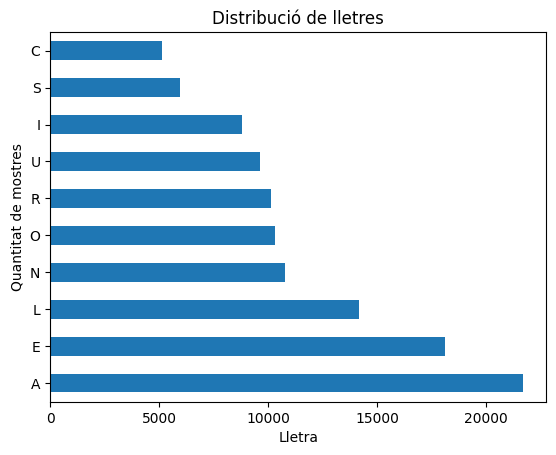

nombre
A    21687
E    18122
L    14201
N    10797
O    10319
R    10160
U     9636
I     8816
S     5945
C     5128
Name: count, dtype: int64


In [10]:
letter_count = train_data['nombre'].value_counts()

letter_count[:10].plot(kind='barh')
plt.title('Distribució de lletres')
plt.xlabel('Lletra')
plt.ylabel('Quantitat de mostres')
plt.show()

print(letter_count[:10])

## Preprocessing Images for Training

In [11]:
class HandwritingDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_encoded = self.label_encoder.fit_transform(self.df.iloc[:, 1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        label = self.labels_encoded[idx]  # Use the encoded label

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to a standard size
    transforms.ToTensor(),  # Convert image to tensor
])

In [13]:
# Adjusting the size of train_data to 3000 samples
train_data = train_data.sample(n=3000, random_state=42)

# Adjusting the size of valid_data to 300 samples
valid_data = valid_data.sample(n=300, random_state=42)

In [14]:
train_dataset = HandwritingDataset(root_dir='train_letters/', csv_file="written_letters_train.csv", transform=transform)
valid_dataset = HandwritingDataset(root_dir='valid_letters/', csv_file="written_letters_validation.csv", transform=transform)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Verify de data loaders work correctly:

In [16]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape)  # This will give you the shape of the batch of images
    print(labels.shape)  # And this will give you the shape of the batch of labels
    break  # Just to demonstrate, stop after the first batch

Batch 0:
torch.Size([32, 1, 28, 28])
torch.Size([32])


## Training function

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

## Initialize model

In [18]:
def initialize_model(num_classes):
    # Resnet18
    model = models.resnet18(pretrained = False)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True) # YOUR CODE HERE!

    input_size = 224

    return model, input_size

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# Number of classes in the dataset
num_classes = len(alphabets) + 1 # +1 for ctc pseudo blank

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Run Training and Validation

In [19]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train fors
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.00001)

dataloaders_dict = {"train": train_loader, "valid": valid_loader}

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7841 Acc: 0.8022
valid Loss: 0.4096 Acc: 0.9012

Epoch 1/14
----------
train Loss: 0.3766 Acc: 0.9068
valid Loss: 0.3462 Acc: 0.9193

Epoch 2/14
----------
train Loss: 0.3081 Acc: 0.9259
valid Loss: 0.3268 Acc: 0.9251

Epoch 3/14
----------
train Loss: 0.2694 Acc: 0.9362
valid Loss: 0.3169 Acc: 0.9274

Epoch 4/14
----------
train Loss: 0.2374 Acc: 0.9441
valid Loss: 0.3182 Acc: 0.9273

Epoch 5/14
----------
train Loss: 0.2106 Acc: 0.9496
valid Loss: 0.3194 Acc: 0.9289

Epoch 6/14
----------
train Loss: 0.1866 Acc: 0.9555
valid Loss: 0.3258 Acc: 0.9273

Epoch 7/14
----------
train Loss: 0.1642 Acc: 0.9603
valid Loss: 0.3321 Acc: 0.9290

Epoch 8/14
----------
train Loss: 0.1421 Acc: 0.9648
valid Loss: 0.3404 Acc: 0.9273

Epoch 9/14
----------
train Loss: 0.1243 Acc: 0.9683
valid Loss: 0.3527 Acc: 0.9280

Epoch 10/14
----------
train Loss: 0.1097 Acc: 0.9716
valid Loss: 0.3675 Acc: 0.9272

Epoch 11/14
----------
train Loss: 0.0965 Acc: 0.9746
valid Loss

In [20]:
torch.save(model.state_dict(), 'cnn_model_v1.pth')

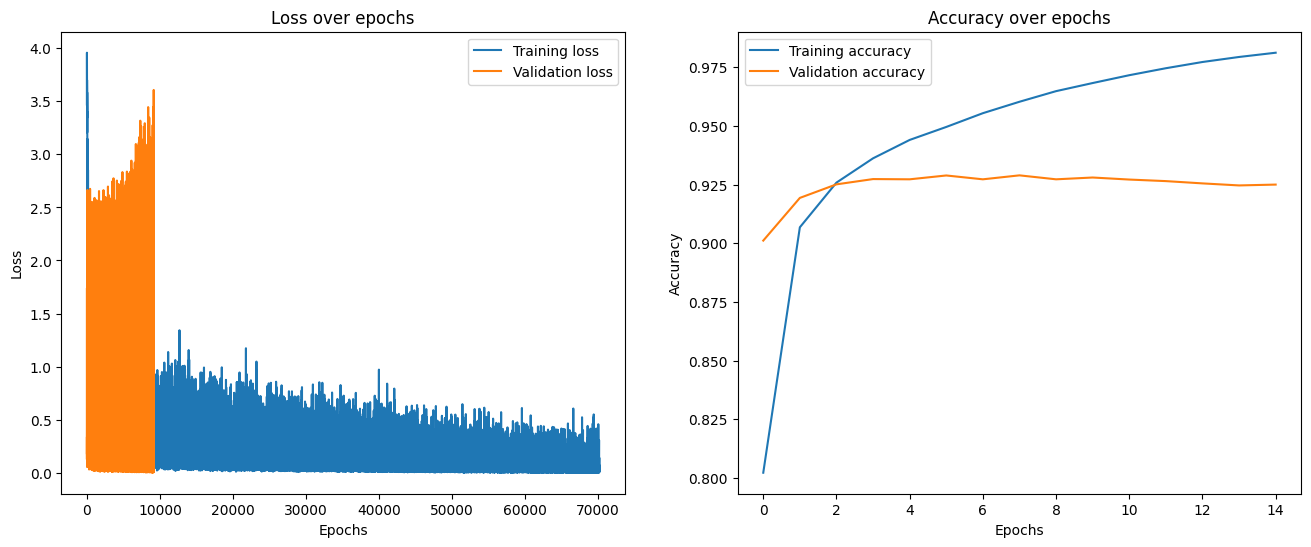

In [21]:
# plot the losses and accuracies
train_losses = [loss.cpu().detach().numpy() for loss in losses["train"]]
val_losses = [loss.cpu().detach().numpy() for loss in losses["valid"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation losses
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracies
ax2.plot([acc.cpu().detach().numpy() for acc in hist['train']], label='Training accuracy')
ax2.plot([acc.cpu().detach().numpy() for acc in hist['valid']], label='Validation accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()